#Model Ensembling
By Chris Fenaroli, Delaney Granizo-Mackenzie, and Max Margenot 

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

## What is Model Ensembling?

Model ensembling is the name for a variety of methods which combine information from many *independent* prediction models to obtain results with more predictive power than any of its components alone. An model ensemble takes these component forecasts and uses some logic to combine them into a final prediction.

Ensembling plays a vital role in developing accurate predictive models and even employing basic ensembling techniques can in many cases drastically improve predictive performance.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.stats as stats
import scipy.linalg as linalg
from statsmodels import regression
import statsmodels.api as sm

## Why Combine Models?

A common approach to model selection is a "winner takes all" process where the best single model is chosen to make predictions. While intuitive and more interpretable than an ensemble, selecting only a single model to base predictions upon has weaknesses as follows:

* Diversifying your prediction through ensembling reduces variance of predictions
* Should a model begin failing, a large ensemble prevents it from greatly affecting predictions while a single-model approach would be ruined
* Helps prevent overfitting by not assigning any single approach a significant amount of weight 

### Caveats

Important to note is that the benefits of model ensembling will only be seen if the models being combined are at least somewhat independent. Aggregating many very similar models will have a much smaller benefit than aggregating ones with distinct insights.

Let's define two $I.I.D.$ (independent and identically distributed) standard normal toy models `m_1` and `m_2`, and see what happens to their mean and standard deviation when we average their predictions over 1000 trials.

---- Mean ----                          ---- Variance ----      
Model 1:        -0.029                   Model 1:        1.014          
Model 2:        0.015                    Model 2:        1.038          
Combined:       -0.007                   Combined:       0.514          

Covariance between models: 0.00281306569105


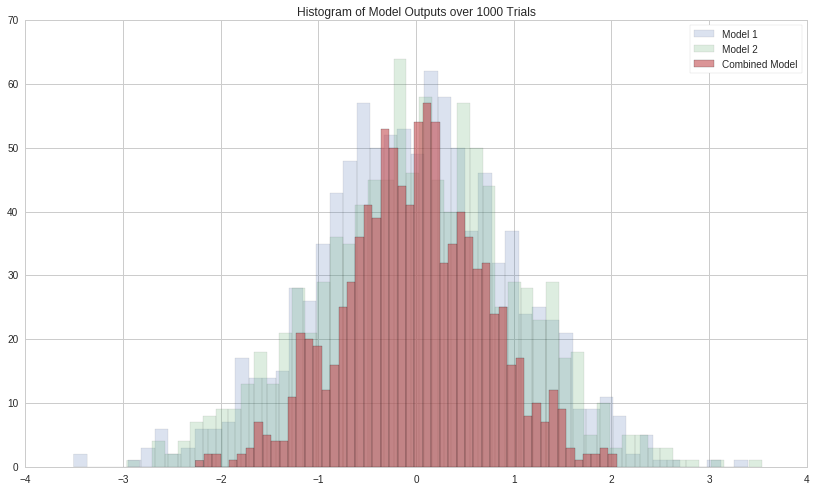

In [37]:
mu = 0
sigma = 1

# Create two identical models
m_1 = np.random.normal(mu,sigma,1000)
m_2 = np.random.normal(mu,sigma,1000)

# Combine them
m_cm = (m_1 + m_2)/2

# Plot their distribution over 1000 trials
plt.hist(m_1, bins=50, alpha=0.2);
plt.hist(m_2, bins=50, alpha=0.2);
plt.hist(m_cm, bins=50, alpha=0.6);
plt.legend(['Model 1', 'Model 2', 'Combined Model'])
plt.title('Histogram of Model Outputs over 1000 Trials')

print "%-39s %-24s" % ('---- Mean ----', '---- Variance ----')
print "%-15s %-24s %-15s %-15s" % ('Model 1:', 
                                   np.round(np.mean(m_1),decimals=3), 
                                   'Model 1:', 
                                   np.round(np.std(m_1)**2,decimals=3))
print "%-15s %-24s %-15s %-15s" % ('Model 2:', 
                                   np.round(np.mean(m_2),decimals=3), 
                                   'Model 2:', 
                                   np.round(np.std(m_2)**2,decimals=3))
print "%-15s %-24s %-15s %-15s" % ('Combined:', 
                                   np.round(np.mean(m_cm),decimals=3),
                                   'Combined:',
                                   np.round(np.std(m_cm)**2,decimals=3))
print "\nCovariance between models:", np.cov(m_1, m_2)[1][0]

## Benefits of Ensembling: Symbolic Intuition

When the $I.I.D.$ models are aggregated, the mean stays the same while the variance of results decreases. Can this be explained symbolically? 

Consider two models with the same mean $m$, the same variance $v$, and zero covariance:

$$ models = \hat{\theta_1} \: , \: \hat{\theta_2}$$

$$E[\hat{\theta_1}]=E[\hat{\theta_2}]=m \:\:\:\:\:\:\:\: Var[\hat{\theta_1}] = Var[\hat{\theta_2}] = v \:\:\:\:\:\:\:\: Cov[\hat{\theta_2},\hat{\theta_2}] = 0$$

When averaged they form a combined model $\hat{\theta_{cm}}$: 

$$\hat{\theta_{cm}} = \frac{\hat{\theta_1} + \hat{\theta_2}}{2}$$ 

$$E[\hat{\theta_{cm}}] = \frac{E[\hat{\theta_1}]+E[\hat{\theta_2}]}{2} = m$$

$$Var[\hat{\theta_{cm}}] = \frac{Var[\hat{\theta_{1}}]+Var[\hat{\theta_{2}}]+2Cov[\hat{\theta_{1}},\hat{\theta_{2}}]}{4} = \frac{v}{2}$$

*Where the combined model keeps the same mean $m$ as its components but sees a reduction in variance.*

### Importance of Model Independence

Should the models being aggregated have a correlation of 1 (equivalent to a covariance of $v$), the variability-reducing effect no longer applies. Instead, the $2Cov[\hat{\theta_{1}},\hat{\theta_{2}}]$ term becomes equal to $2v$ in turn making variance equal to it's original value $v$. The significance of this is that the magnitude of the variance remains unchanged should the models being combined be perfectly correlated, illustrating the importance of the models being uncorrelated.

### Averaging $n$ Models

Now let's look at a combined model $\hat{\theta_{cm}}$ that is the average of $n$ $I.I.D$ models.

$$\hat{\theta_{cm}} = \frac{\sum_{i=1}^{n}{\hat{\theta_i}}}{n}$$

$$Var[\hat{\theta_{cm}}] = \frac{\sum_{i=1}^{n}{Var[\hat{\theta_i}}] + 2\sum_{1 \le i<j \le n}^{n}{Cov[\hat{\theta_i},\hat{\theta_j}]}}{n^2} = \frac{nv}{n^2} = \frac{v}{n}$$

This shows how if the models are perfectly uncorrelated, the ensemble's variance will decrease geometrically. Let's go back to our simulation and increase the number of models being combined:

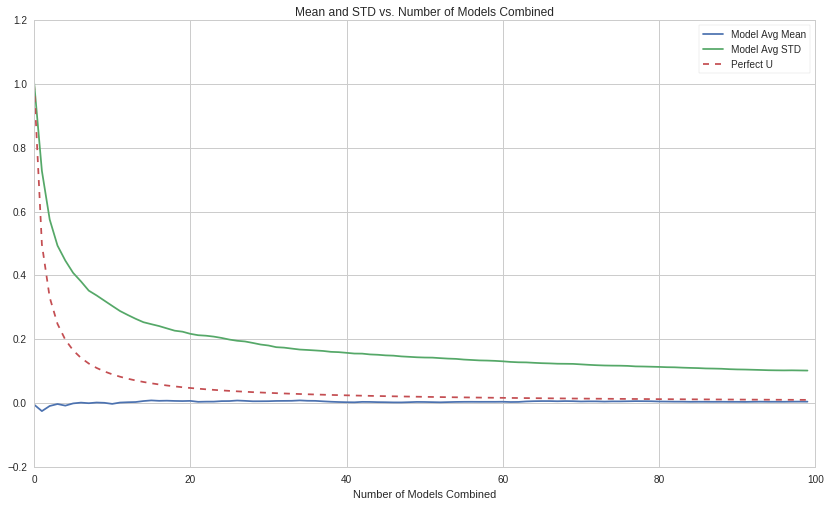

In [296]:
# Number of identical models
n = 100

# Initizalize n models
models = np.array([np.random.normal(mu,sigma,1000) for _ in range(n)])

combined_models = [np.mean(models[0:i+1], axis=0) for i in range(n)]
means = np.mean(combined_models,axis=1)
stds = np.std(combined_models,axis=1)

plt.plot(means);
plt.plot(stds);
plt.plot(range(n), 1/np.linspace(1,n+1,n), linestyle = '--')
plt.legend(['Model Avg Mean', 'Model Avg STD', 'Perfect U']);
plt.xlabel('Number of Models Combined');
plt.title('Mean and STD vs. Number of Models Combined');

As more models are added the mean predicted value is stationary and the prediction variability decreases geometrically. Worth noting, however, is that in this simulation the standard deviation did not decrease at the rate perfectly uncorrelated models would. This is a result of the toy models we used having some level of covariance, purely by random chance.




## Benefits of Ensembling: Dimension Intuition

The theory and simulation above demonstrate the benefits of simply averaging uncorrelated models; in both cases, as more models are averaged the mean stays the same but variance decreases. Model combination gets its power from the diversity of uncorrelated models ensuring that different features of the problem are represented. But what are these "features" that data apparently has? And how do combinations of diverse models help reveal them?

An interesting analogy is to think of a model as a specific "view" of the world, having its own perspective and unique insights into the problem at hand. Data can have many "dimensions" and rarely will one model encapture every single one; only by approaching it from many views can we understand its structure.

Consider a 3-dimensional object, such as a cylinder. To fully understand what this object is we require multiple perspectives from distinct viewpoints, as from each viewpoint alone you only see a 2-d projection of the space the cylinder takes up. To illustrate the limitations of attempting to understand a multi-dimensional structure from a single view, imagine looking at a cylinder from a specific viewpoint to the side and trying to decipher what it could be:

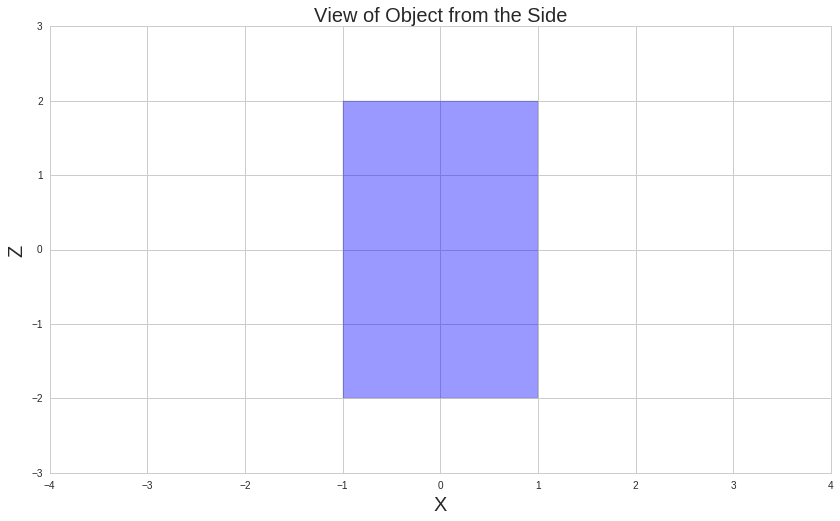

In [39]:
plt.fill_between([-1,0,1], -2, 2, facecolor='blue', alpha = 0.4);
plt.xlim(-4,4);
plt.ylim(-3,3);
plt.xlabel("X", fontsize=20);
plt.ylabel("Z", fontsize=20);
plt.title('View of Object from the Side', fontsize=20);

From this perspective alone we have no information on the object's presence in the $Y$ dimension; our only conclusion can be that the 3-d object is constrained in the $X$ and $Z$ dimensions by the rectangle defined by [-1,1] and [-2,2] respectively. 

Beyond that, we can not tell if the shape is a prism, cylinder, or any number of possible objects that fit those constraints. The "variability" of our understanding is high, and can only be diminished by supplementing our current perspective with an additional "view." 

Let's add another view by looking at the same object, this time from above instead of from the side:

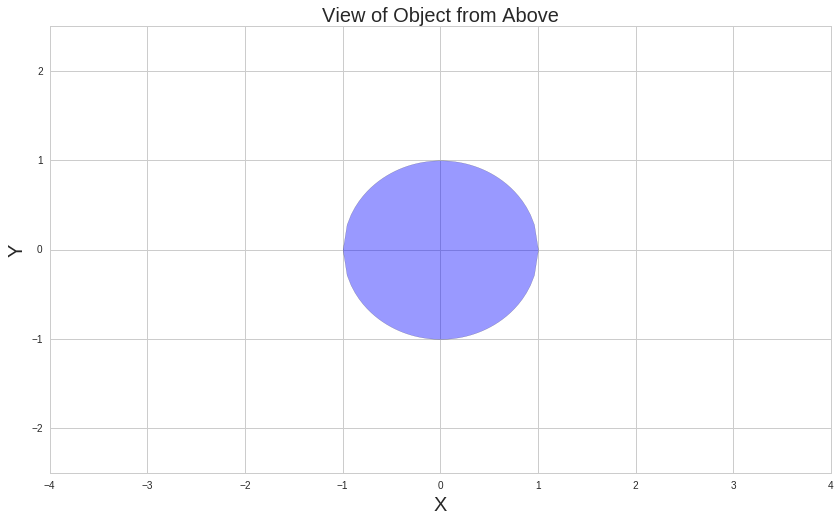

In [40]:
X = np.linspace(-1,1,50)
plt.fill_between(X, -np.sqrt(1-X**2), np.sqrt(1-X**2), facecolor='blue', alpha = 0.4);
plt.xlim(-4,4);
plt.ylim(-2.5,2.5);
plt.xlabel("X", fontsize=20);
plt.ylabel("Y", fontsize=20);
plt.title('View of Object from Above', fontsize=20);

After adding this second view we can be positive that the shape, if not a cylinder, is restricted to the space of
a cylinder with a unit circle base an height ranging from [-2,2].

Individually, neither of these perspectives would provide a particularly enlightening idea of the shape being looked at. With the first view, we had no information on the object in the $Y$ dimension, and in the second view we gained no information on the $Z$ dimension. When combined, however, we can make conclusions based on all three dimensions and the size of the set of possible shapes is drastically reduced. 

This is the idea behind model ensembling; the aggregation of multiple perspectives yields a more complete view than any of them alone.


## Example: Predicting Consumer Staples Sector ETF (XLP)

Let's bring this analogy of uncorrelated models providing "perspectives" to one involving data. Where the cylinder above was a function of space in the $X$,$Y$, and $Z$ dimensions, let's consider an ETF that tracks the consumer staples sector (XLP), with the following possible explanatory dimensions:

* US unemployment rate
* US inflation rate
* price of gold
* USD vs. EUR exchange rate

The first step will be to import these macro indicators, which are all available as free [Quantopian Data Feeds](quantopian.com/data), and standardize them keeping in mind that:

* The specific inflation and unemployment datasets we are using have one month intervals, so time index intervals cannot be anything smaller than monthly
* The unemployment data is released at the start of the month after the relevant month and inflation rate data is released ~3 weeks after so we must shift both back a month from the asof_date to prevent look-ahead bias
* Gold prices must be shifted back one day from asof_date to prevent look-ahead bias
* Equity pricing data only goes back to 2002, so we can only consider data from 2002 on

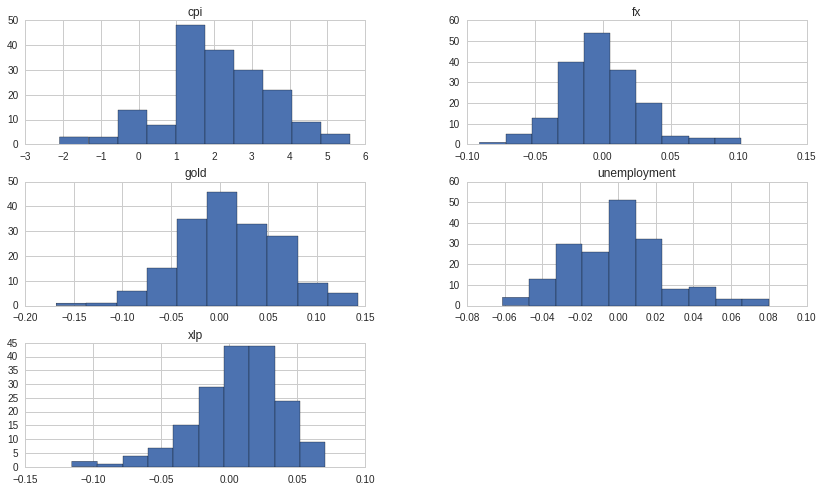

In [295]:
from quantopian.interactive.data.quandl import fred_unrate as unemployment_bz
from quantopian.interactive.data.quandl import rateinf_inflation_usa as inflation_bz
from quantopian.interactive.data.quandl import bundesbank_bbk01_wt5511 as gold_bz
from quantopian.interactive.data.quandl import currfx_usdeur as fx_bz

import blaze as bz
from odo import odo

# Start date dictated by sector ETF XLP
start = '2002-01-01'
end = '2017-01-01'

# Sample period will be 2010-2014
s = '2010-01-01'
e = '2015-01-01'

index = pd.date_range(start=start, end = end, freq= 'MS')

# Migrating Blaze expressions into Pandas DataFrames and setting index
unemployment = odo(unemployment_bz, pd.DataFrame).set_index(['asof_date'])
inflation = odo(inflation_bz, pd.DataFrame)
inflation = inflation.set_index(inflation['asof_date'] + pd.Timedelta('1 days'))
gold = odo(gold_bz[gold_bz.asof_date >= start], pd.DataFrame).set_index(['asof_date'])
fx = odo(fx_bz, pd.DataFrame).set_index(['asof_date'])
xlp = get_pricing('XLP', start_date=start, end_date=end, fields = 'price')

data = pd.DataFrame(columns = ['unemployment','cpi','gold','fx','xlp'],
                    index = index[1:])

# Adjusting data along points mentioned above and putting into a Pandas DataFrame
data['unemployment'] = unemployment.shift().loc[index].ffill()['value'][1:]
data['gold'] = gold['value'].sort_index().asof(index).ffill()[1:]
data['fx'] = fx['rate'].sort_index().asof(index).ffill()[1:]
data['xlp'] = xlp.asof(index).ffill()[1:]

# Finding first order differences; 
# differences are more likely to be stationary and normally distributed
data = data.pct_change()[1:]

# Inflation is already a first order difference of the consumer price index
# therefore we will leave it alone
data['cpi'] = inflation.shift().loc[index].ffill()['value'][1:]

# Plot histograms for each variable
data.hist(bins=10);

A OLS fitted simple linear regression returns a single set of coefficients that minimizes the sum of squared residuals within the training set. This model is simply an estimate. It will usually have bias (difference betwen model expected value and true value) and variance (sensitivity to small changes in the training set). As we add more models, we should see the aggregate model have a higher $R^2$ as the model leaves less and less unexplained variance.

Let's begin by attempting to model `xlp` returns using four different models, each a simple linear regresion with exactly one explanatory variable. We'll also define a linear regression plotting function to make this step simpler.

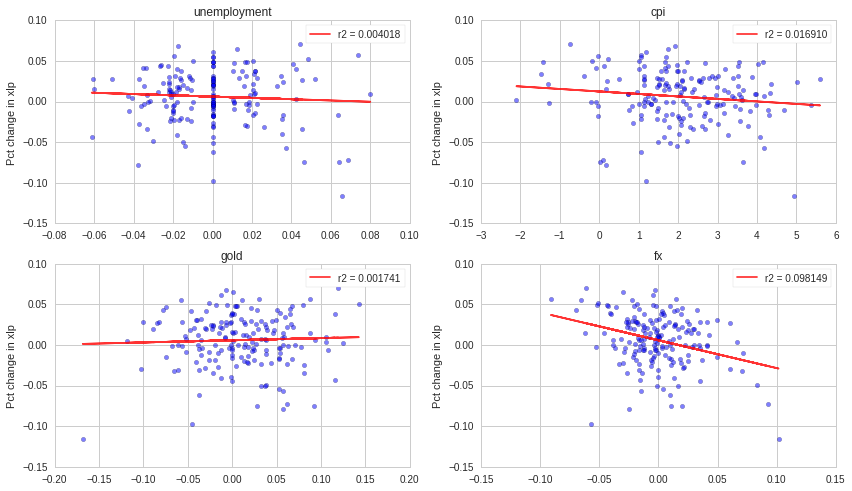

In [292]:
# Choose which dimension we want to model using the others
exog = 'xlp'

# Defining our linear regression function
def linreg_r2(X,Y):

    Xc = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, Xc).fit()
    params = model.params
    Y_hat = np.dot(Xc,params)
    
    return model

# Creating a figure with a grid of regressions
ncols = 2
nrows = (len(data.columns)-1)/ncols
fig, axes = plt.subplots(ncols=ncols,nrows=nrows)

# iterating through and plotting regressions
for i, dimension in enumerate(data.columns[data.columns != exog]):
    
    model = linreg_r2(data[dimension], data[exog])
    
    ax = axes[(i)/ncols, i%ncols]
    ax.scatter(data[dimension], data[exog], alpha = 0.5)
    ax.plot(data[dimension], model.predict(), alpha = 0.8, c='r')
    ax.set_title(dimension);
    ax.set_ylabel('Pct change in %s'%exog);
    ax.legend(['r2 = %5f'%model.rsquared]);

None of the above four models explains a satisfactory amount of the variance in returns of `xlp`. `fx`, the USD-EUR exchange rate, explains the most with an $R^2$ value of 9.81%. The least insightful dimension is the change in the price of gold, `gold`, which only explains 0.1% of the variance in `xlp` returns.

Using only one dimension to try and understand a multi-dimensional dataset like in this example is equivalent to trying to categorize a 3-d object as a cylinder by only approaching it from a single perspective. It can not be done. In this model alone we ignore many features of the data and it can be improved by ensembling independent views.

Each of these dimensions provides unique insight into the problem of predicting the returns of `xlp`. Let's now average the predictions of all four models, combining their unique insights, to see if we can build a more accurate model:

*Note: In the below plot, the blue line is not the model but the line $predicted=observed$. Points along this line mean the combined model perfectly predicted the observed returns of `xlp`.*

rsquared: 0.909701113542


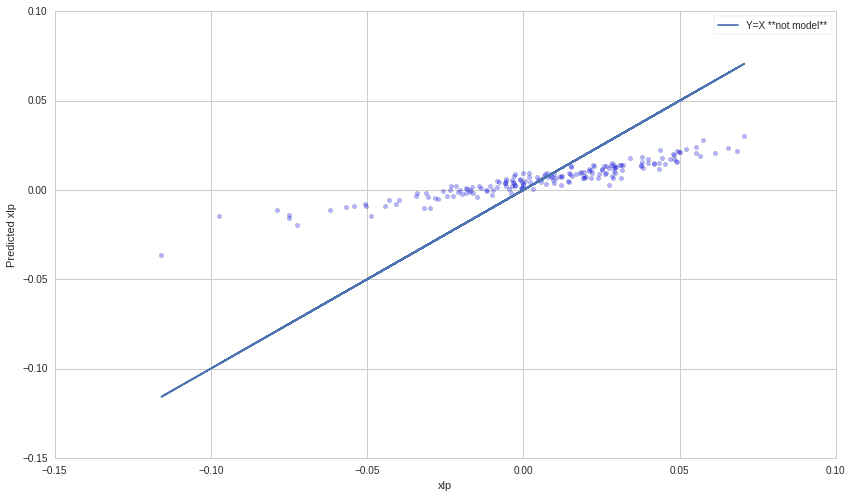

In [293]:
combined = np.mean([linreg_r2(data[_], data[exog]).predict() for _ in data.columns[data.columns != 'unemployment']], axis=0)

plt.scatter(data[exog],combined, alpha = 0.3);
plt.plot(data[exog],data[exog], label='Y=X **not model**');
plt.xlabel(exog);
plt.ylabel('Predicted %s'%exog);
plt.legend();

print 'rsquared:', np.corrcoef(combined, data[exog])[0][1]**2

By taking a simple equally weighted average of all the models we saw $R^2$ increase dramatically to 90.97%. The $R^2$ values of the individual single-dimension models were 0.4%, 1.7%, 0.2%, and 9.8%. The $R^2$ of the combined model was dramatically higher than all of the previous ones combined. 

### More Dimensions Exist

We got a relatively good $R^2$ of 90.97% with the above model using only four data dimensions. However, there are still many more dimensions beyond the four we used (`fx`,`cpi`,`unemployment`, and `gold`) that could help fill out the last 10% such as:

* Broad market ETFs like SPY or IWM
* Models which take into account interactions between dimensions like [multiple linear regression](https://www.quantopian.com/lectures/multiple-linear-regression)
* ... and probably many more

Furthermore, oftentimes datasets do not have obvious dominant dimensions. In this situation you must develop a set of many possible influencers and whittle it down to only the most significant ones through techniques like [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction). 

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*